In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 4.9 MB/s 


In [ ]:
import pandas as pd
import math
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
import random
import imblearn
from imblearn.over_sampling import SMOTE
from tqdm.auto import tqdm
import itertools
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def fill_missing_values(df, method):
  if method == 'mean':
    df.fillna(df.mean(), inplace=True)
  elif method == 'median':
    df.fillna(df.median(), inplace=True)
  elif method == 'mode':
    for column in df.columns:
      print(column)
      df[column].fillna(df[column].mode()[0], inplace=True)
  return df

# feature selection
def select_features(df, columns=None, no_of_columns=None):
  if columns:
    df = df[columns]
  return df

def get_df(orig_df, method, columns=None, no_of_columns=None):
  df = orig_df
  df = select_features(df, columns, no_of_columns)
  df = fill_missing_values(df, method)
  return df

# train_test_split
def tt_split(df, X_cols=None, y_col=None):
  train_df, test_df = train_test_split(df, test_size=0.2)
  X_train = np.array(train_df[X_cols])
  y_train = np.array(train_df[y_col])
  X_test = np.array(test_df[X_cols])
  y_test = np.array(test_df[y_col])
  return train_df, test_df, X_train, y_train, X_test, y_test

In [ ]:
def get_top_2_accuracy(y_pred_top_2, y_train):
    correct = 0
    for i in range(len(y_train)):
        if y_train[i] in list(y_pred_top_2[i]):
            correct += 1
    return correct / len(y_train)

def get_3_class_accuracy(y_pred, y_train):
    conversion = {'CN': 'CN', 'SMC': 'MCI', 'EMCI': 'MCI', 'LMCI': 'MCI', 'AD': 'AD'}
    correct = 0
    for i in range(len(y_train)):
        if conversion[y_train[i]] == conversion[y_pred[i]]:
            correct += 1
    return correct / len(y_train)

def get_top2_tp(class_name,y_true,y_top2_pred):
    tp=0
    for i in range(len(y_true)):
        if (y_true[i]==class_name)and(class_name in y_top2_pred[i]):
            tp+=1
    return tp

def get_top2_fp(class_name,y_true,y_top2_pred):
    fp=0
    for i in range(len(y_true)):
        if ((y_true[i] not in y_top2_pred[i])and(class_name in y_top2_pred[i])):
            fp+=1
    return fp

def get_top2_fn(class_name,y_true,y_top2_pred):
    fn=0
    for i in range(len(y_true)):
        if ((y_true[i]==class_name)and(class_name not in y_top2_pred[i])):
            fn+=1
    return fn

def get_pr(tp,fp):
    alpha=0
    if(tp+fp==0):
      alpha=0.000001
    return (tp+alpha)/(tp+fp+alpha)

def get_re(tp,fn):
    alpha=0
    if(tp+fn==0):
      alpha=0.000001
    return tp/(tp+fn)

RF MODEL

In [ ]:
file_path='/content/gdrive/MyDrive/Temporal_Data.csv'
df = pd.read_csv(file_path)
df = df[df.VISCODE=='bl']
df.drop_duplicates()
feature_column_names = ['CDRSB_bl', 'MMSE_bl', 'FAQ_bl', 'MOCA_bl', 'RAVLT_learning_bl', 'PTEDUCAT', 'RAVLT_immediate_bl' , 'ADAS13_bl', 'AGE', 'RAVLT_perc_forgetting_bl']
predicted_class_names = ['DX_bl']
other_columns = ['RID', 'VISCODE']
fields = feature_column_names + predicted_class_names+other_columns
df = get_df(df, method='mode', columns=fields)
train_df, test_df, X_train, y_train, X_test, y_test = tt_split(df, feature_column_names, predicted_class_names[0])
labels = np.array(train_df[predicted_class_names[0]])
features = train_df.drop(predicted_class_names+other_columns, axis=1)
feature_list = list(features.columns)
features = np.array(features)
classes=np.array(sorted(list(set(labels))))

CDRSB_bl
MMSE_bl
FAQ_bl
MOCA_bl
RAVLT_learning_bl
PTEDUCAT
RAVLT_immediate_bl
ADAS13_bl
AGE
RAVLT_perc_forgetting_bl
DX_bl
RID
VISCODE


In [ ]:
rfc=RandomForestClassifier(random_state=1)
param_grid = {
    'n_estimators': [50,100],
    'max_features': [3,4,5,6,7,8,9,10],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2,3,4]
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100]},
             verbose=1)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# gbc=GradientBoostingClassifier(random_state=1)
# param_grid = {
#     'n_estimators': [50,100],
#     'max_features': [3,4,5,6,7,8,9,10],
#     'max_depth' : [1,2,3,4,5,6,7,8,9,10],
#     'criterion' :['gini', 'entropy'],
#     'min_samples_split': [2,3,4]
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1)
# CV_rfc.fit(X_train, y_train)

xgbc = XGBClassifier()
param_grid = {
'learning_rate': [0.1, 0.5, 1],
'n_estimators': [50,100],
'max_depth': [1,2,3,4,5,6]
}
CV_xgbc = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv= 5,verbose=2)
CV_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=2, n_

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [50, 100]},
             verbose=2)

In [ ]:
print(CV_xgbc.best_params_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [ ]:
xgb_cls = XGBClassifier(**CV_xgbc.best_params_)
xgb_cls.fit(X_train, y_train)
xgb_explainer = shap.TreeExplainer(xgb_cls)
xgb_shap_values = xgb_explainer.shap_values(X_train)


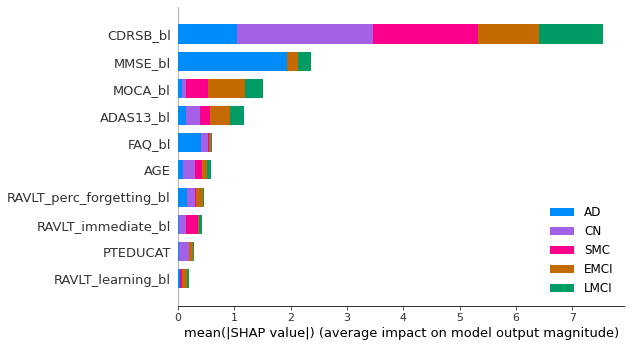

In [ ]:
shap.summary_plot(xgb_shap_values, train_df[feature_column_names].values, plot_type="bar", class_names= classes, feature_names = train_df[feature_column_names].columns)

In [ ]:
CV_xgbc.classes_

array(['AD', 'CN', 'EMCI', 'LMCI', 'SMC'], dtype=object)

AD


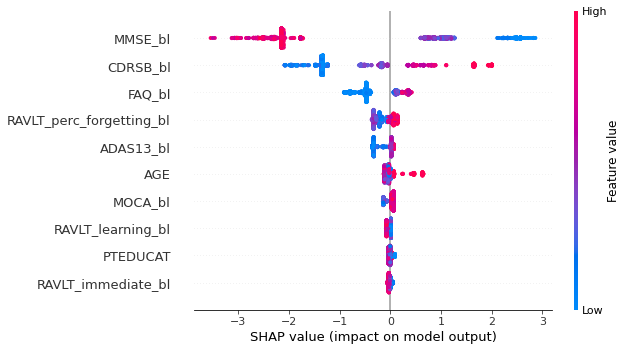

CN


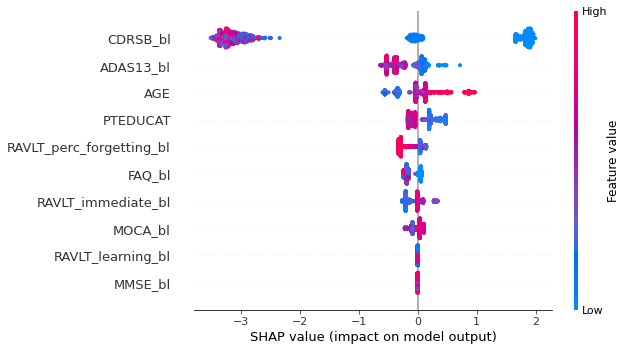

EMCI


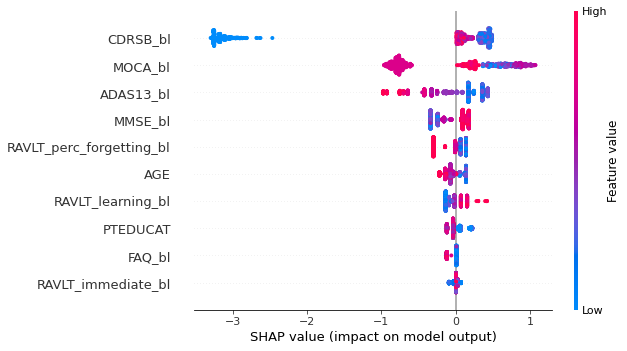

LMCI


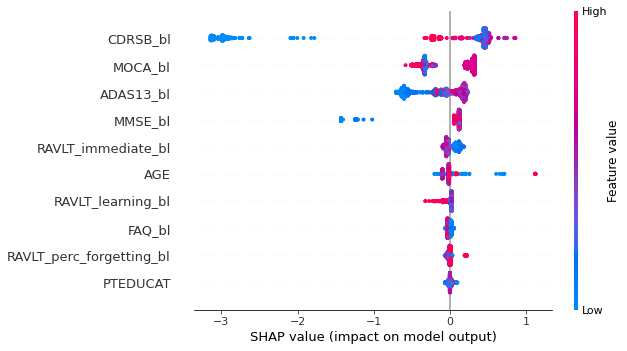

SMC


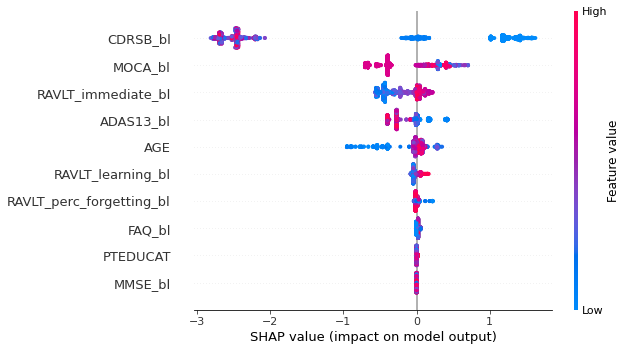

In [ ]:
for i in range(len(classes)):
  print(classes[i])
  shap.summary_plot(xgb_shap_values[i], train_df[feature_column_names].values, feature_names = train_df[feature_column_names].columns)

In [ ]:
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 100}


In [ ]:
cls = RandomForestClassifier(**CV_rfc.best_params_)
cls.fit(X_train, y_train)
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_train)


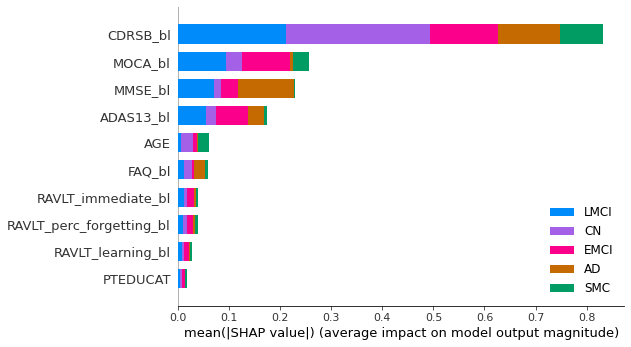

In [ ]:
shap.summary_plot(shap_values, train_df[feature_column_names].values, plot_type="bar", class_names= classes, feature_names = train_df[feature_column_names].columns)

In [ ]:
CV_rfc.classes_

array(['AD', 'CN', 'EMCI', 'LMCI', 'SMC'], dtype=object)

AD


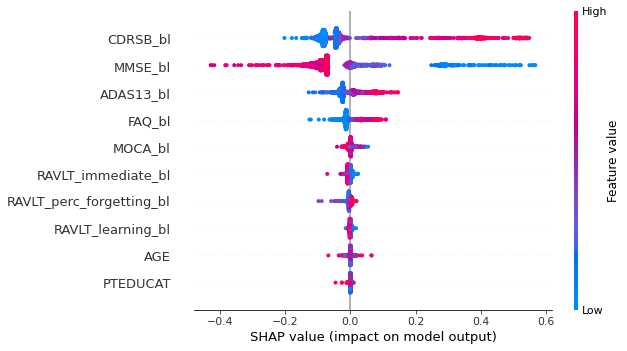

CN


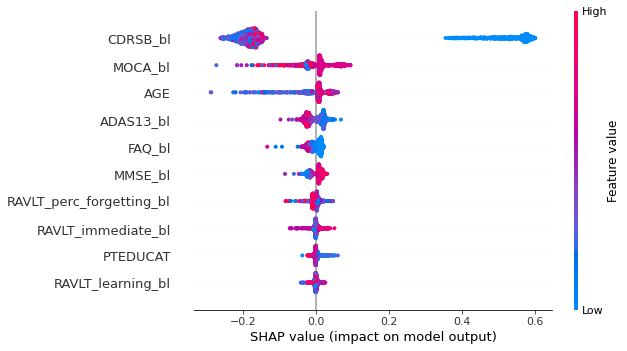

EMCI


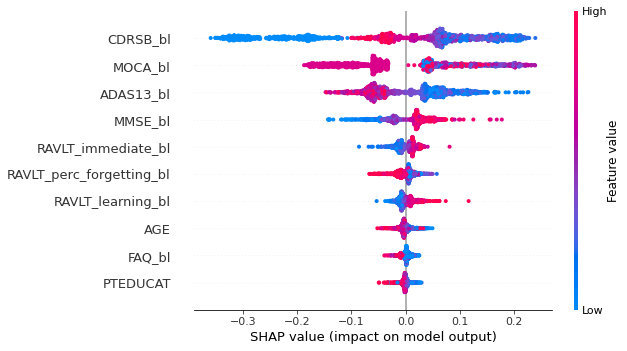

LMCI


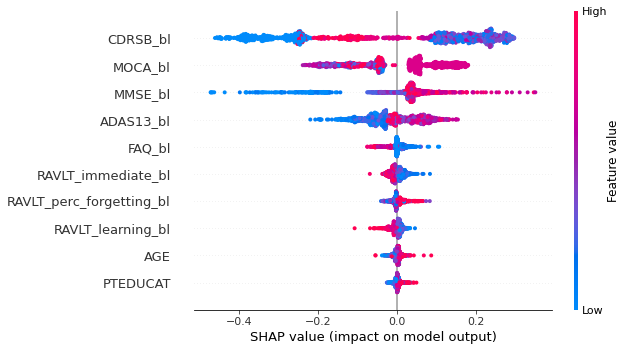

SMC


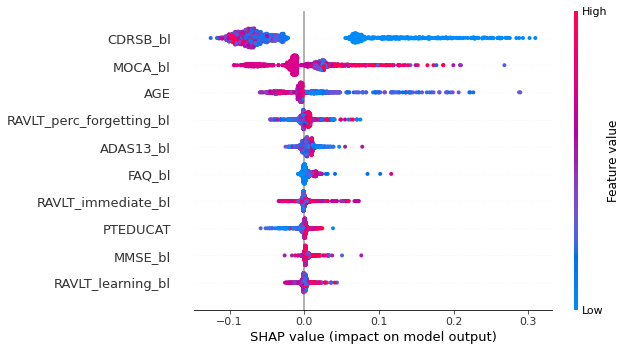

In [ ]:
for i in range(len(classes)):
  print(classes[i])
  shap.summary_plot(shap_values[i], train_df[feature_column_names].values, feature_names = train_df[feature_column_names].columns)

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e719aa3503f9e82522f3c06e402ebc7b7b6f6107ed1b22d5a1ce8a176f036f3e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
predict_fn_rf = lambda x: cls.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(train_df[feature_column_names].values,feature_names = train_df[feature_column_names].columns,class_names=CV_rfc.classes_,kernel_width=5)

In [ ]:
xgb_predict_fn_rf = lambda x: xgb_cls.predict_proba(x).astype(float)
xgb_explainer = lime.lime_tabular.LimeTabularExplainer(train_df[feature_column_names].values,feature_names = train_df[feature_column_names].columns,class_names=CV_xgbc.classes_,kernel_width=5)

In [ ]:
choosen_instance = test_df[feature_column_names].iloc[21].values
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10, top_labels=5)
exp.show_in_notebook(show_all=False)

In [ ]:
xgb_choosen_instance = test_df[feature_column_names].iloc[21].values
xgb_exp = explainer.explain_instance(choosen_instance, xgb_predict_fn_rf,num_features=10, top_labels=5)
xgb_exp.show_in_notebook(show_all=False)

In [ ]:
test_df.head(25)

CDRSB_bl  MMSE_bl  FAQ_bl  MOCA_bl  RAVLT_learning_bl  PTEDUCAT  \
5637        4.0       25    20.0     21.0                3.0        16   
10195       6.0       23    26.0     15.0                1.0         9   
2645        0.5       30     4.0     25.0                3.0        17   
279         0.0       30     0.0     25.0                9.0        15   
9123        1.0       29     4.0     26.0                6.0        20   
2150        0.0       30     0.0     25.0                7.0        20   
4641        0.5       28     2.0     21.0                3.0        14   
2285        1.5       28     6.0     25.0                6.0        20   
1192        2.0       28     4.0     25.0                9.0        18   
9799        1.0       28     2.0     20.0                3.0        12   
943         1.0       25     4.0     25.0                3.0        14   
10583       0.0       30     1.0     30.0                8.0        18   
53          0.0       26     0.0     25.0                7.0        14   
3877        1.0       29     2.0     20.0                4.0        12   
9070        8.0       21    12.0     25.0                0.0        12   
3692        6.0       24    16.0     24.0                2.0        15   
2298        2.0       28     6.0     25.0                0.0        18   
3759        2.0       29     1.0     23.0                4.0        16   
528         1.5       25     3.0     25.0                3.0        16   
2236        1.0       30     3.0     25.0                3.0        17   
1891        0.0       28     0.0     25.0                6.0        16   
4290        3.0       27    11.0     23.0                3.0        18   
4367        0.0       29     0.0     24.0                1.0        20   
4235        5.5       25     9.0     21.0                3.0        12   
3739        0.5       30     0.0     22.0                7.0        18   

       RAVLT_immediate_bl  ADAS13_bl   AGE  RAVLT_perc_forgetting_bl DX_bl  \
5637                 25.0      34.00  79.3                 100.00000  LMCI   
10195                18.0      36.00  86.5                 100.00000    AD   
2645                 38.0      11.33  74.2                  37.50000  LMCI   
279                  42.0      12.00  73.2                  33.33330    CN   
9123                 46.0      10.00  73.1                  -9.09091  EMCI   
2150                 41.0       6.00  76.8                  58.33330    CN   
4641                 30.0      21.00  84.7                  62.50000  LMCI   
2285                 41.0      10.00  67.4                  36.36360  LMCI   
1192                 40.0      18.00  68.9                  15.38460  LMCI   
9799                 29.0      25.00  70.9                  50.00000  EMCI   
943                  33.0      18.67  74.6                 100.00000  LMCI   
10583                66.0       6.00  63.9                   6.66667    CN   
53                   40.0       8.00  71.7                  63.63640    CN   
3877                 26.0      19.00  83.0                 100.00000  EMCI   
9070                 21.0      32.00  83.4                 100.00000    AD   
3692                 26.0      24.00  64.0                 100.00000    AD   
2298                 27.0      21.67  73.3                 100.00000  LMCI   
3759                 23.0       9.00  74.2                  28.57140  EMCI   
528                  24.0      18.33  71.1                 100.00000  LMCI   
2236                 32.0      15.00  72.3                  71.42860  LMCI   
1891                 31.0      11.67  80.3                  80.00000    CN   
4290                 27.0      18.00  70.0                  71.42860  LMCI   
4367                 38.0      16.00  84.7                  25.00000    CN   
4235                 25.0      26.00  71.1                  66.66670    AD   
3739                 47.0       5.00  71.2                  15.38460  EMCI   

        RID VISCODE  
5637   4542      bl  
10195  45

In [ ]:
test_df[feature_column_names].iloc[[0]].values

array([[  4. ,  25. ,  20. ,  21. ,   3. ,  16. ,  25. ,  34. ,  79.3,
        100. ]])

In [ ]:
choosen_instance

array([ 3.    , 27.    , 11.    , 23.    ,  3.    , 18.    , 27.    ,
       18.    , 70.    , 71.4286])

In [ ]:
y_train

array(['CN', 'AD', 'CN', ..., 'EMCI', 'LMCI', 'EMCI'], dtype=object)

In [ ]:
test_df.iloc[[0]]

CDRSB_bl  MMSE_bl  FAQ_bl  MOCA_bl  RAVLT_learning_bl  PTEDUCAT  \
5637       4.0       25    20.0     21.0                3.0        16   

      RAVLT_immediate_bl  ADAS13_bl   AGE  RAVLT_perc_forgetting_bl DX_bl  \
5637                25.0       34.0  79.3                     100.0  LMCI   

       RID VISCODE  
5637  4542      bl

In [ ]:
test_df

CDRSB_bl  MMSE_bl  FAQ_bl  MOCA_bl  RAVLT_learning_bl  PTEDUCAT  \
5637        4.0       25    20.0     21.0                3.0        16   
10195       6.0       23    26.0     15.0                1.0         9   
2645        0.5       30     4.0     25.0                3.0        17   
279         0.0       30     0.0     25.0                9.0        15   
9123        1.0       29     4.0     26.0                6.0        20   
...         ...      ...     ...      ...                ...       ...   
932         3.5       20    16.0     25.0                1.0        17   
5314        0.0       29     0.0     26.0                5.0        18   
4906        3.5       26     6.0     21.0                3.0        18   
4205        2.5       30    11.0     22.0                2.0        11   
4789        2.0       30     1.0     26.0                6.0        15   

       RAVLT_immediate_bl  ADAS13_bl   AGE  RAVLT_perc_forgetting_bl DX_bl  \
5637                 25.0      34.00  79.3                 100.00000  LMCI   
10195                18.0      36.00  86.5                 100.00000    AD   
2645                 38.0      11.33  74.2                  37.50000  LMCI   
279                  42.0      12.00  73.2                  33.33330    CN   
9123                 46.0      10.00  73.1                  -9.09091  EMCI   
...                   ...        ...   ...                       ...   ...   
932                  18.0      36.00  84.6                 100.00000    AD   
5314                 53.0       9.00  73.9                  16.66670   SMC   
4906                 28.0      22.00  74.0                  85.71430    AD   
4205                 28.0       8.00  88.6                  83.33330  EMCI   
4789                 37.0      12.00  65.8                  20.00000  EMCI   

        RID VISCODE  
5637   4542      bl  
10195  4583      bl  
2645   1210      bl  
279     106      bl  
9123   2052      bl  
...     ...     ...  
932     392      bl  
5314   5250      bl  
4906   5054      bl  
4205   4476      bl  
4789   4907      bl  

[348 rows x 13 columns]

In [ ]:
def get_top_2_accuracy(y_pred_top_2, y_train):
    correct = 0
    for i in range(len(y_train)):
        if y_train[i] in list(y_pred_top_2[i]):
            correct += 1
    return correct / len(y_train)

def get_3_class_accuracy(y_pred, y_train):
    conversion = {'CN': 'CN', 'SMC': 'MCI', 'EMCI': 'MCI', 'LMCI': 'MCI', 'AD': 'AD'}
    correct = 0
    for i in range(len(y_train)):
        if conversion[y_train[i]] == conversion[y_pred[i]]:
            correct += 1
    return correct / len(y_train)

def get_top2_tp(class_name,y_true,y_top2_pred):
    tp=0
    for i in range(len(y_true)):
        if (y_true[i]==class_name)and(class_name in y_top2_pred[i]):
            tp+=1
    return tp

def get_top2_fp(class_name,y_true,y_top2_pred):
    fp=0
    for i in range(len(y_true)):
        if ((y_true[i] not in y_top2_pred[i])and(class_name in y_top2_pred[i])):
            fp+=1
    return fp

def get_top2_fn(class_name,y_true,y_top2_pred):
    fn=0
    for i in range(len(y_true)):
        if ((y_true[i]==class_name)and(class_name not in y_top2_pred[i])):
            fn+=1
    return fn

def get_pr(tp,fp):
    alpha=0
    if(tp+fp==0):
      alpha=0.000001
    return (tp+alpha)/(tp+fp+alpha)

def get_re(tp,fn):
    alpha=0
    if(tp+fn==0):
      alpha=0.000001
    return tp/(tp+fn)

In [ ]:
res = dict()
y_pred_proba = cls.predict_proba(X_test)
y_pred_top_2 = [classes[(-x).argsort()[:2]] for x in y_pred_proba]
y_pred = [x[0] for x in y_pred_top_2]
top_2_accuracy = get_top_2_accuracy(y_pred_top_2, y_test)
accuracy_3_class = get_3_class_accuracy(y_pred, y_test)
res['cr'] = classification_report(y_true=y_test, y_pred=y_pred, target_names=classes, output_dict=True)
res['top_2_acc'] = top_2_accuracy
res['3_class'] = accuracy_3_class
top2_tp=dict()
top2_fp=dict()
top2_fn=dict()
top2_pr=dict()
top2_re=dict()
for class_name in classes:
  top2_tp[class_name]=get_top2_tp(class_name,y_test,y_pred_top_2)
  top2_fp[class_name]=get_top2_fp(class_name,y_test,y_pred_top_2)
  top2_fn[class_name]=get_top2_fn(class_name,y_test,y_pred_top_2)
  top2_pr[class_name]=get_pr(top2_tp[class_name],top2_fp[class_name])
  top2_re[class_name]=get_re(top2_tp[class_name],top2_fn[class_name])
res['top_2_tp'] = top2_tp
res['top_2_fp'] = top2_fp
res['top_2_fn'] = top2_fn
res['top_2_pr'] = top2_pr
res['top_2_re'] = top2_re


In [ ]:
xgb_res = dict()
y_pred_proba = xgb_cls.predict_proba(X_test)
y_pred_top_2 = [classes[(-x).argsort()[:2]] for x in y_pred_proba]
y_pred = [x[0] for x in y_pred_top_2]
top_2_accuracy = get_top_2_accuracy(y_pred_top_2, y_test)
accuracy_3_class = get_3_class_accuracy(y_pred, y_test)
xgb_res['cr'] = classification_report(y_true=y_test, y_pred=y_pred, target_names=classes, output_dict=True)
xgb_res['top_2_acc'] = top_2_accuracy
xgb_res['3_class'] = accuracy_3_class
top2_tp=dict()
top2_fp=dict()
top2_fn=dict()
top2_pr=dict()
top2_re=dict()
for class_name in classes:
  top2_tp[class_name]=get_top2_tp(class_name,y_test,y_pred_top_2)
  top2_fp[class_name]=get_top2_fp(class_name,y_test,y_pred_top_2)
  top2_fn[class_name]=get_top2_fn(class_name,y_test,y_pred_top_2)
  top2_pr[class_name]=get_pr(top2_tp[class_name],top2_fp[class_name])
  top2_re[class_name]=get_re(top2_tp[class_name],top2_fn[class_name])
xgb_res['top_2_tp'] = top2_tp
xgb_res['top_2_fp'] = top2_fp
xgb_res['top_2_fn'] = top2_fn
xgb_res['top_2_pr'] = top2_pr
xgb_res['top_2_re'] = top2_re


In [ ]:
res

{'3_class': 0.8850574712643678,
 'cr': {'AD': {'f1-score': 0.8799999999999999,
   'precision': 0.9482758620689655,
   'recall': 0.8208955223880597,
   'support': 67},
  'CN': {'f1-score': 0.8538011695906432,
   'precision': 0.8111111111111111,
   'recall': 0.9012345679012346,
   'support': 81},
  'EMCI': {'f1-score': 0.7571428571428572,
   'precision': 0.7361111111111112,
   'recall': 0.7794117647058824,
   'support': 68},
  'LMCI': {'f1-score': 0.8034934497816595,
   'precision': 0.7479674796747967,
   'recall': 0.8679245283018868,
   'support': 106},
  'SMC': {'f1-score': 0.06451612903225806,
   'precision': 0.2,
   'recall': 0.038461538461538464,
   'support': 26},
  'accuracy': 0.7873563218390804,
  'macro avg': {'f1-score': 0.6717907211094836,
   'precision': 0.688693112793197,
   'recall': 0.6815855843517203,
   'support': 348},
  'weighted avg': {'f1-score': 0.7656647530294569,
   'precision': 0.7579729631025998,
   'recall': 0.7873563218390804,
   'support': 348}},
 'top_2_acc'

In [ ]:
xgb_res

{'3_class': 0.896551724137931,
 'cr': {'AD': {'f1-score': 0.9147286821705426,
   'precision': 0.9516129032258065,
   'recall': 0.8805970149253731,
   'support': 67},
  'CN': {'f1-score': 0.8554913294797687,
   'precision': 0.8043478260869565,
   'recall': 0.9135802469135802,
   'support': 81},
  'EMCI': {'f1-score': 0.7669172932330828,
   'precision': 0.7846153846153846,
   'recall': 0.75,
   'support': 68},
  'LMCI': {'f1-score': 0.826086956521739,
   'precision': 0.7661290322580645,
   'recall': 0.8962264150943396,
   'support': 106},
  'SMC': {'f1-score': 0.06451612903225806,
   'precision': 0.2,
   'recall': 0.038461538461538464,
   'support': 26},
  'accuracy': 0.8045977011494253,
  'macro avg': {'f1-score': 0.6855480780874782,
   'precision': 0.7013410292372424,
   'recall': 0.6957730430789664,
   'support': 348},
  'weighted avg': {'f1-score': 0.7815362990783916,
   'precision': 0.7720510402367055,
   'recall': 0.8045977011494253,
   'support': 348}},
 'top_2_acc': 0.94540229885